## Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.tabular.all import *
import os

# Welcome to A Simple Quick Start Guide on Using Fastai Tabular Learner

**Source**: [fastai](https://docs.fast.ai/)

#### About fastai

fastai is a deep learning library which provides practitioners with high-level components that can quickly and easily provide state-of-the-art results in standard deep learning domains, and provides researchers with low-level components that can be mixed and matched to build new approaches. It aims to do both things without substantial compromises in ease of use, flexibility, or performance. This is possible thanks to a carefully layered architecture, which expresses common underlying patterns of many deep learning and data processing techniques in terms of decoupled abstractions. These abstractions can be expressed concisely and clearly by leveraging the dynamism of the underlying Python language and the flexibility of the PyTorch library. fastai includes:

- A new type dispatch system for Python along with a semantic type hierarchy for tensors
- A GPU-optimized computer vision library which can be extended in pure Python
- An optimizer which refactors out the common functionality of modern optimizers into two basic pieces, allowing optimization algorithms to be implemented in 4–5 lines of code
- A novel 2-way callback system that can access any part of the data, model, or optimizer and change it at any point during training
- A new data block API


fastai is organized around two main design goals: to be approachable and rapidly productive, while also being deeply hackable and configurable. It is built on top of a hierarchy of lower-level APIs which provide composable building blocks. This way, a user wanting to rewrite part of the high-level API or add particular behavior to suit their needs does not have to learn how to use the lowest level.

#### Layered API

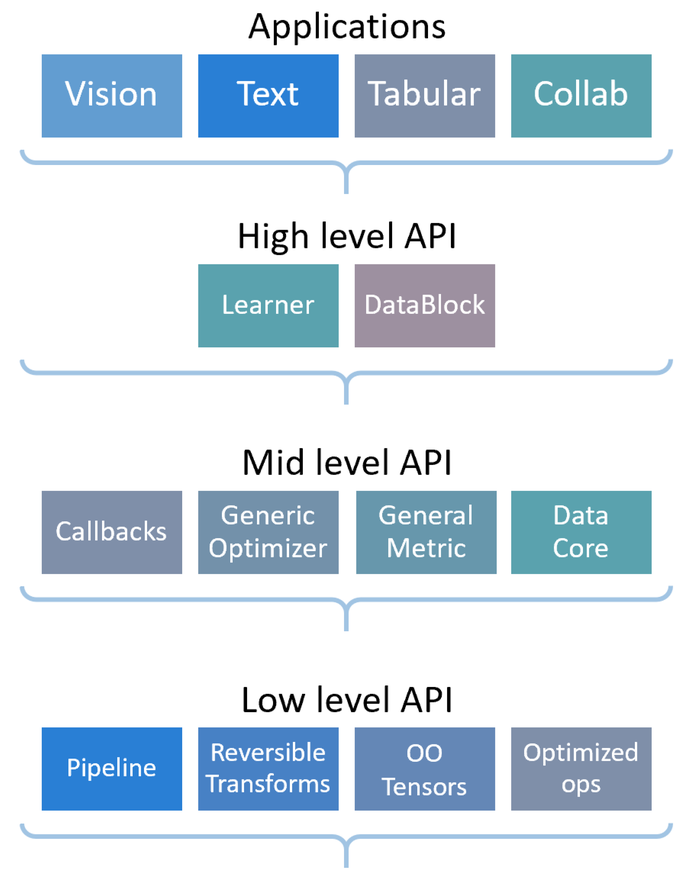

## Load Data into Pandas Dataframes

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [3]:
# Optional (Build one this), some minor feature engineering to have more features for example below
df['Date'] = pd.to_datetime(df['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Create Month Feature
df['month'] = df['Date'].dt.month
test['month'] = test['Date'].dt.month

## Building a Fastai Model

#### Create train-validation splits

In [4]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df)) # Same as Train-Test Split in sklearn

#### Create a dataset object from Dataframes that Fastai can use

In [5]:
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['month'],
                   cont_names = ['ID','Longitude', 'Latitude'],
                   y_names='Value',
                   splits=splits)

##### We are using the *TabularPandas* class from the fastai library to create a tabular dataset for machine learning tasks. 
- **TabularPandas**: This is a class provided by the fastai library for handling tabular data in machine learning tasks. It expects the following arguments:
  - **df**: It represents the input DataFrame containing the tabular data.
  - **procs**: It specifies a list of data preprocessing transformations to be applied to the input DataFrame. In this code snippet, three preprocessing transformations are specified:
    - **Categorify**: This transformation converts categorical variables into a numerical representation suitable for machine learning models.
    - **FillMissing**: This transformation fills missing values in the DataFrame with appropriate values.
    - **Normalize**: This transformation normalizes the continuous variables in the DataFrame.
  -  **cat_names**: It specifies the names of the categorical variables in the DataFrame. In this code snippet, the only categorical variable specified is 'month'.
  - **cont_names**: It specifies the names of the continuous variables in the DataFrame. In this code snippet, the continuous variables specified are 'ID', 'Longitude', and 'Latitude'.
  - **y_names**: It specifies the name of the target variable (dependent variable) in the DataFrame. In this code snippet, the target variable is 'Value'.
  - **splits**: It specifies the data splits to be used during training and validation. The 'splits' variable likely contains information about how to split the data into training and validation sets.

#### To extract the dataset objects back into pandas dataframes we can extract the following attributes .xs and .ys

In [6]:
to.xs.head()

,month,ID,Longitude,Latitude
582233,6,1.132893,0.679285,-0.562049
132064,8,-1.082264,1.114113,0.633418
201995,10,-0.738153,-0.323102,-1.022231
42302,7,-1.523958,0.360106,-0.384085
102610,5,-1.227199,0.570526,-1.008205


In [7]:
to.ys.head()

,Value
582233,0.0080
132064,0.0400
201995,0.2000
42302,1.3200
102610,0.0039


#### Next we need to make a dataloader object to feed into our model on training iterations, for it we can decide a batch size which will affect how often the model weights are updated on each training cycle or epoch

In [8]:
dls = to.dataloaders(bs=128)

In [9]:
dls.show_batch()

,month,ID,Longitude,Latitude,Value
0,5,317383.999548,-90.466782,30.040960,0.0890
1,2,358742.000075,-79.298195,33.347904,0.0080
2,3,653278.991939,-118.193054,34.006390,0.0630
3,1,105602.991422,-88.116470,41.526886,0.0100
4,10,30694.003221,-75.118057,39.978611,2.2100
5,7,171049.995648,-90.160477,38.612034,0.0100
6,11,64365.988240,-85.415024,40.158417,0.8900
7,7,217532.005251,-87.938950,41.901421,0.0500
8,2,338639.999863,-121.458496,38.556328,0.0500
9,3,605191.999979,-91.150108,30.491857,0.0906


#### Time to Train the Model, luckily for us, fastai knows if the task is regression or classification based on the y-values and the error metric provided.

In [10]:
learn = tabular_learner(dls, metrics=mse) # Establish learner

Some other metrics: mae, rmse, r2_score, accuracy

In [11]:
learn.fit(n_epoch=1) # Train learner

epoch,train_loss,valid_loss,mse,time
0,1.736519,0.990141,0.990141,00:52


In [12]:
learn.show_results() # Show sample of training results

,month,ID,Longitude,Latitude,Value,Value_pred
0,7.0,-1.370855,0.542930,-0.346449,0.020,0.200273
1,8.0,-0.397969,0.058271,0.001067,1.380,0.770203
2,3.0,-0.391370,-2.027533,0.060243,0.061,0.078864
3,6.0,-1.530291,-0.506061,-2.108887,0.000,-0.033421
4,3.0,1.022339,0.109055,0.128085,1.850,0.624638
5,5.0,-1.356531,0.802908,0.565501,0.060,0.205609
6,9.0,0.500152,-0.083763,1.530540,0.000,0.221422
7,10.0,-0.960555,-0.227329,-1.644214,0.050,-0.036890
8,5.0,0.191923,-0.011194,1.891410,0.002,0.109995


## Inference

In [13]:
# Predict on the test set
dl = learn.dls.test_dl(test) # Transform test data similar to our dataset object from train data
preds = learn.get_preds(dl=dl)

preds = [x.item() for x in preds[0]] # Reformat data away from list of tensors
sub['Value'] = preds
sub.to_csv('sub.csv', index = None)